In [1]:
#Loading in appropriate packages
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
import requests
import time
import json
from bs4 import BeautifulSoup
import sys
from scipy import stats
from sklearn.cross_validation import *

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

In [2]:

#Loading in Relevant Dataframes
master = pd.read_csv('data/lahman/Master.csv')
pitching = pd.read_csv('data/lahman/Pitching.csv')
smalldf = pd.read_csv('data/small.csv')

In [3]:
pitching.columns

Index([u'playerID', u'yearID', u'stint', u'teamID', u'lgID', u'W', u'L', u'G', u'GS', u'CG', u'SHO', u'SV', u'IPouts', u'H', u'ER', u'HR', u'BB', u'SO', u'BAOpp', u'ERA', u'IBB', u'WP', u'HBP', u'BK', u'BFP', u'GF', u'R', u'SH', u'SF', u'GIDP'], dtype='object')

In [4]:
#Ben's intro code
retro_to_lah = dict(zip(master['retroID'], master['playerID']))
lah_to_retro = dict(zip(master['playerID'], master['retroID']))
retro_to_hand = dict(zip(master['retroID'], master['throws']))
#pitcherIDs = smalldf['pID'].unique()#RetroIDs
#L_pitcherIDs = [retro_to_lah[name] for name in pitcherIDs] #LahmanIDs
#grouped =  pitching.groupby('playerID').sum().reset_index()
#mask = np.in1d(grouped.playerID, L_pitcherIDs)
#pitcher_sums = grouped[mask]

In [124]:
smalldf.tail()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
109683,lorem001,wrigj001,23,7,27,R,0,3,11,4,lorem001_wrigj001,0.304348,0.407407,3859,1127,4260,70,403,1836,401,0.292045,0.358685,270,0.094601,0.094131,0.264554,4521,1334,5273,48,612,2484,752,0.295067,0.395600,307,0.116063,0.142613,0.252987
109684,lorem001,wrigj002,14,3,15,R,0,2,3,1,lorem001_wrigj002,0.214286,0.266667,3859,1127,4260,70,403,1836,401,0.292045,0.358685,270,0.094601,0.094131,0.264554,2011,573,2306,22,344,1078,295,0.284933,0.376409,163,0.149176,0.127927,0.248482
109685,lorem001,yatet001,7,2,8,R,0,2,2,1,lorem001_yatet001,0.285714,0.375000,3859,1127,4260,70,403,1836,401,0.292045,0.358685,270,0.094601,0.094131,0.264554,237,58,274,2,51,117,37,0.244726,0.346715,29,0.186131,0.135036,0.211679
109686,lorem001,zambc001,12,3,15,R,0,1,5,3,lorem001_zambc001,0.250000,0.400000,3859,1127,4260,70,403,1836,401,0.292045,0.358685,270,0.094601,0.094131,0.264554,5407,1333,6250,56,1173,2481,843,0.246532,0.348160,304,0.187680,0.134880,0.213280
109687,lorem001,zitob001,24,4,27,L,0,4,4,3,lorem001_zitob001,0.166667,0.259259,3859,1127,4260,70,403,1836,401,0.292045,0.358685,270,0.094601,0.094131,0.264554,7549,1932,8542,97,1342,3700,993,0.255928,0.342426,406,0.157106,0.116249,0.226177


In [125]:
pitching.tail()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
43325,yateski01,2014,1,TBA,AL,0,2,37,0,0,0,1,108,33,15,4,15,42,0.241,3.75,3,2,3,0,156,12,16,0,1,2
43326,youngch03,2014,1,SEA,AL,12,9,30,29,0,0,0,495,143,67,26,60,108,0.234,3.65,3,5,3,1,688,0,70,4,9,6
43327,zeidjo01,2014,1,HOU,AL,0,0,23,0,0,0,0,62,30,16,6,7,18,0.345,6.97,1,1,1,0,98,6,18,1,2,1
43328,zieglbr01,2014,1,ARI,NL,5,3,68,0,0,0,1,201,60,26,5,24,54,0.243,3.49,6,0,3,0,281,11,29,2,4,9
43329,zimmejo02,2014,1,WAS,NL,14,5,32,32,3,2,0,599,185,59,13,29,182,0.244,2.66,0,4,6,0,800,0,67,5,3,11


#Pitchers Simulation Formula
Start with a thousand and then subtract the following:

One point for each difference of 1 win.

One point for each difference of 2 losses.

One point for each difference of .002 in winning percentage (max 100 
points).

One point for each difference of .02 in ERA (max 100 points).

One point for each difference of 10 games pitched.

One point for each difference of 20 starts.

One point for each difference of 20 complete games.

One point for each difference of 50 innings pitched.

One point for each difference of 50 hits allowed.

One point for each difference of 30 strikeouts.

One point for each difference of 10 walks.

One point for each difference of 5 shutouts.

One point for each difference of 3 saves.

If they throw with a different hand and are starters subtract 10, relievers 25. For relievers you halve the winning percentage penalty. For all pitchers, the winning percentage penalty can be no larger than 1.5 times the wins and losses penalty. Relievers are defined as more relief appearances than starts and less than 4.00 innings per appearance.
We plugged all this in to create the lists you see on the player pages. Note that a player must have 100 innings pitched or 500 at bats before being considered, and to be truly accurate you need to look at whole careers, but it is fun to speculate all the same.

In [45]:
def compute_supports(df):
    ubids=df.bID.unique()
    pitch = df.groupby('pID').bID.unique()
    bdict={}
    for e,v in zip(pitch.index.values, pitch.values):
        bdict[e] = np.array([item in v for item in ubids])
    pitchers=bdict.keys()
    supports=[]
    for i,p1 in enumerate(pitchers):
        for j,p2 in enumerate(pitchers):
            if  i < j:
                supmask = (bdict[p1] & bdict[p2])
                common_batters = np.sum(supmask)
                supports.append(common_batters)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, bdict

In [46]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all conglomerations recomputed
    this is used when a frame is subsetted.
    """
    ldfb=ldf.groupby('bID')
    ldfp=ldf.groupby('pID')
    nldf=ldf.copy()
    
    #Conglomerate pitcher stats
    nldf.set_index(['pID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ovp_'+col] = ldfp[col].sum()
    nldf['ovp_AVG'] = nldf['ovp_H']/nldf['ovp_AB']
    nldf['ovp_FACED']= ldfp.AB.count()
    nldf['ovp_OBP'] = (nldf['ovp_H'] + nldf['ovp_W'])/nldf['ovp_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ovp_' + col + '_PCT'] = nldf['ovp_' + col] / nldf['ovp_PA']
    nldf.reset_index(inplace=True)
    
    #Conglomerate batter stats
    nldf.set_index(['bID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ov_'+col] = ldfb[col].sum()
    nldf['ov_AVG'] = nldf['ov_H']/nldf['ov_AB']
    nldf['ov_FACED']= ldfb.AB.count()
    nldf['ov_OBP'] = (nldf['ov_H'] + nldf['ov_W'])/nldf['ov_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ov_' + col + '_PCT'] = nldf['ov_' + col] / nldf['ov_PA']
    nldf.reset_index(inplace=True)
    return nldf

In [47]:
##input is the smalldf rows corresponding to the 2 pitcher ids
def pitcher_sim_alt(p1, p2):
    #Wins and Losses Penalties
    win_diff=np.abs(int(p1['W'])-int(p2['W'])) #1 pt for each win
    loss_diff=np.abs(int(p1['L'])-int(p2['L']))/2. #1 pt each 2 losses
    
    #Winning Percentage Penalty
    if int(p1['REL'])==1:     #winning percentage is halved for relief pitchers
        p1['WiP']=p1['WiP']/2.
    if int(p2['REL'])==1:
        p2['WiP']=p2['WiP']/2.
    wip_diff=np.abs(float(p1['WiP'])-float(p2['WiP']))/.002 #1 pt diff of winning percentage of 0.002 
    if wip_diff > 1.5*(win_diff+loss_diff): #winning percentage cannot be more than 1.5 times the penalties for win/loss differences 
        wip_diff= 1.5*(win_diff+loss_diff)
    if wip_diff >100: #penalty for winning percentage has a max= 100
        wip_diff=100   
    era_diff=np.abs(float(p1['ERA'])-float(p2['ERA']))/0.02 #1 pt diff of ERA of 0.02
    if era_diff >100:
        era_diff=100 #max =100
    
    #Handedness Penalties conditional on both pitchers being relief pitchers or not 
    if p1['RL'].values[0]!=p2['RL'].values[0] and int(p1['REL'])==0 and int(p2['REL'])==0: #handedness is different, relief pitchers
        hand_diff=10. 
    elif p1['RL'].values[0]!=p2['RL'].values[0] and int(p1['REL'])==1 and int(p2['REL'])==1.: #handedness is different, starters
        hand_diff=25.  
    else:
        hand_diff=0.
    
    #Additional Penalties
    gp_diff=np.abs(int(p1['G'])-int(p2['G']))/10. #1 pt for diff of 10 games played
    st_diff=np.abs(int(p1['GS'])-int(p2['GS']))/20. #1 pt for diff of 20 games started
    cg_diff=np.abs(int(p1['CG'])-int(p2['CG']))/20. #1 pt for diff of 20 games completed
    ip_diff=np.abs(float(p1['IP'])-float(p2['IP']))/50. #1 pt for diff of 50 innings pitched
    h_diff=np.abs(int(p1['H'])-int(p2['H']))/50. #1 pt for diff of 50 hits allowed
    so_diff=np.abs(int(p1['SO'])-int(p2['SO']))/30. #1 pt for diff of 30 strikeouts
    bb_diff=np.abs(int(p1['BB'])-int(p2['BB']))/50. #1 pt for diff of 10 walks
    sho_diff=np.abs(int(p1['SHO'])-int(p2['SHO']))/5. #1 pt for diff of 5 shutouts
    sv_diff=np.abs(int(p1['SV'])-int(p2['SV']))/3. #1 pt for diff of 3 saves

    score=1000 #generating starting score and subtracting penalties
    final_score=score-(win_diff+loss_diff+wip_diff+era_diff+gp_diff+st_diff+cg_diff+
                       ip_diff+h_diff+so_diff+bb_diff+sho_diff+sv_diff+hand_diff)
    #print final_score

    return final_score

In [48]:
trainlist=np.array([])
testlist=np.array([])
validatelist=np.array([])
take=21 #21 matchups between validation and test set
for k, v in smalldf.groupby('bID'):
    if len(v) > 100: #batter has faced at least 150 pitchers
        train_rows, test_valid_rows = train_test_split(v.matchID.values, test_size=take)
        trainlist = np.append(trainlist,train_rows)
        valid_rows, test_rows = train_test_split(test_valid_rows, test_size=0.4)
        validatelist =np.append(validatelist,valid_rows) 
        testlist = np.append(testlist,test_rows) 
    else:
        trainlist = np.append(trainlist,v.matchID.values)
mask = np.in1d(smalldf.matchID.values, trainlist)
traindf=smalldf[mask]
mask = np.in1d(smalldf.matchID.values, validatelist)
validatedf=smalldf[mask]
mask = np.in1d(smalldf.matchID.values, testlist)
testdf=smalldf[mask]
print traindf.shape, validatedf.shape, testdf.shape

(101036, 39) (4944, 39) (3708, 39)


In [123]:
pitching.tail()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
43325,yateski01,2014,1,TBA,AL,0,2,37,0,0,0,1,108,33,15,4,15,42,0.241,3.75,3,2,3,0,156,12,16,0,1,2
43326,youngch03,2014,1,SEA,AL,12,9,30,29,0,0,0,495,143,67,26,60,108,0.234,3.65,3,5,3,1,688,0,70,4,9,6
43327,zeidjo01,2014,1,HOU,AL,0,0,23,0,0,0,0,62,30,16,6,7,18,0.345,6.97,1,1,1,0,98,6,18,1,2,1
43328,zieglbr01,2014,1,ARI,NL,5,3,68,0,0,0,1,201,60,26,5,24,54,0.243,3.49,6,0,3,0,281,11,29,2,4,9
43329,zimmejo02,2014,1,WAS,NL,14,5,32,32,3,2,0,599,185,59,13,29,182,0.244,2.66,0,4,6,0,800,0,67,5,3,11


In [49]:
traindf=recompute_frame(traindf)
validatedf=recompute_frame(validatedf)
testdf=recompute_frame(testdf)
validatedf=validatedf[['bID', 'pID','AVG']]
testdf=testdf[['bID', 'pID', 'AVG']]
traindf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,schic002,benea001,9,0,9,R,1,4,0,0,schic002_benea001,0.000000,0.000000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,2828,759,3185,45,565,1564,357,0.268388,0.350392,126,0.177394,0.112088,0.238305
1,schic002,browk001,11,1,11,R,0,6,1,0,schic002_browk001,0.090909,0.090909,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4166,1034,4540,41,830,1742,374,0.248200,0.310132,205,0.182819,0.082379,0.227753
2,schic002,fassj001,11,2,11,L,1,5,4,0,schic002_fassj001,0.181818,0.181818,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,2751,767,3069,33,537,1413,318,0.278808,0.353535,167,0.174976,0.103617,0.249919
3,schic002,glavt001,14,3,14,L,1,3,5,0,schic002_glavt001,0.214286,0.214286,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,7083,2010,7881,97,935,3658,798,0.283778,0.356300,265,0.118640,0.101256,0.255044
4,schic002,hampm001,16,2,16,L,1,6,2,0,schic002_hampm001,0.125000,0.125000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4379,1248,4893,49,601,2163,514,0.284997,0.360106,215,0.122829,0.105048,0.255058


In [50]:
ubids=traindf.bID.unique()#unique-user-ids
upids=traindf.pID.unique()#unique-item-ids
ubidmap={v:k for k,v in enumerate(ubids)}#of length U
upidmap={v:k for k,v in enumerate(upids)}#of length M

In [51]:
def get_pitching_totals(pitching_df, upids):
    lah_pitchers = [retro_to_lah[name] for name in upids]
    pitching_totals = pitching.groupby('playerID').sum().reset_index()
    pitching_totals = pitching_totals[np.in1d(pitching_totals['playerID'], lah_pitchers)]
    pitching_totals.head()
    pitching_totals['BB_total'] = pitching_totals['BB'] + pitching_totals['IBB'] + pitching_totals['HBP']
    pitching_totals['pID'] = [lah_to_retro[name] for name in pitching_totals.playerID]
    pitching_totals['RL'] = [retro_to_hand[name] for name in pitching_totals.pID]
    pitching_totals['IP'] = pitching_totals['IPouts']/3.
    pitching_totals['Games']=pitching_totals['GS']-pitching_totals['G']/2. #if positive, more games started than games in relief
    pitching_totals['inningsper']=pitching_totals['IP']/pitching_totals['G'] #innings per game 
    relief=[1 if (i[1]['Games'] < 0. and i[1]['inningsper']<4.) else 0 for i in pitching_totals.iterrows()]
    pitching_totals['REL'] = relief
    pitching_totals['ERA'] = pitching_totals['ER'] *9. / (pitching_totals['IP'])
    pitching_totals['BAOpp'] = (pitching_totals.H + pitching_totals.BB_total) / pitching_totals.BFP #batting average against
    pitching_totals['WiP'] = pitching_totals.W/pitching_totals.G #win percentage

    return pitching_totals[['pID', 'W', 'L', 'ERA', 'RL', 'BAOpp', 'WiP', 'IP', 'REL', 'G', 'GS', 'CG', 'H', 'SO', 'BB', 'SHO', 'SV']]

In [52]:
pitching_totals = get_pitching_totals(pitching, upids)

In [54]:
class Database:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, pindexmap, supports):
        "the constructor, takes a map of restaurant id's to integers"
        database={}
        self.pindexmap=pindexmap
        self.supports=supports
        l_keys=len(self.pindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)

    def set_supports(self, supports):
        self.supports=supports
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.pindexmap[b1]][self.pindexmap[b2]]
        nsup=self.database_sup[self.pindexmap[b1]][self.pindexmap[b2]]
        return (sim, nsup)

In [65]:
class Database_pitch:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, rindexmap):
        "the constructor, takes a map of restaurant id's to integers"
        database={}
        self.rindexmap=rindexmap
        self.inversemap = dict(zip(self.rindexmap.values(), self.rindexmap.keys()))
        l_keys=len(self.rindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.rindexmap[b1]][self.rindexmap[b2]]
        return sim

In [72]:
db=Database_pitch(upidmap)

In [74]:
import cPickle as pickle
#pickle.dump(db,open('pitching_db.p','wb'))
db = pickle.load(open('pitching_db.p','rb'))

In [75]:
smalldf.sort('ovp_FACED').pID.unique()

array(['dotsr001', 'bannf001', 'forsb001', ..., 'hernl003', 'hudst001',
       'buehm001'], dtype=object)

In [76]:
tpair=('buehm001', 'hudst001') # Mark Buehrle vs. Tim Hudson
print db.get(tpair[0],tpair[1])

888.303195498


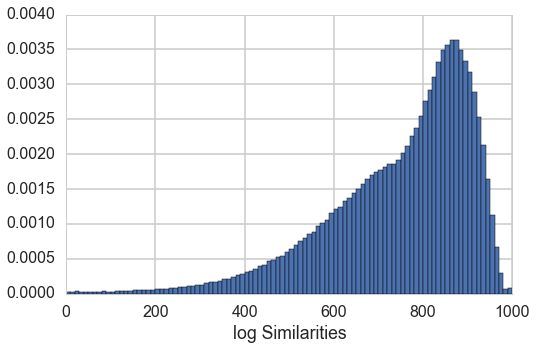

In [132]:
fig, axis = plt.subplots(figsize=(8,5))
sims = db.database_sim.flatten()
axis.hist(sims[sims>=0], bins=100, normed=True)
axis.set_xlabel('log Similarities')

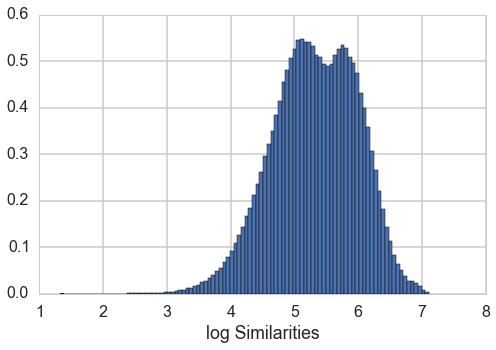

In [131]:
fig, axis = plt.subplots(figsize=(8,5))
sims = np.log(1000-db.database_sim.flatten())
axis.hist(sims[sims>=0], bins=100, normed=True)
axis.set_xlabel('log Similarities')

In [94]:
ybar = traindf.H.sum() / float(traindf.AB.sum())
ybar

0.27395835917280614

In [95]:
predictions={'universal':ybar+np.zeros(len(testdf))}
predictions_valid={'universal':ybar+np.zeros(len(validatedf))}

In [96]:
#your code here
####

#initializing list
list_pred=[]

#for each row in test df:
for row in range(len(testdf)):
    batterid_test=testdf.iloc[row]['bID'] #get the batter
    pitcherid_test=testdf.iloc[row]['pID'] #get the restuarant id
    list_pred.append(ybar+batter_biases[batterid_test]+pitcher_biases[pitcherid_test]) #call biases and calc. pred.
    predictions["baseline"]=list_pred #add to dictionary
print len(predictions['baseline'])

#initializing list
list_pred2=[]
#for each row in validate df:
for row in range(len(validatedf)):
    batterid_val=validatedf.iloc[row]['bID'] #get the batter
    pitcherid_val=validatedf.iloc[row]['pID'] #get the restuarant id
    list_pred2.append(ybar+batter_biases[batterid_val]+pitcher_biases[pitcherid_val])#call biases and calc. pred.
    predictions_valid["baseline"]=list_pred2 #add to dictionary
print len(predictions_valid['baseline'])

3708
4944


In [106]:
def get_batters_pitchers(df, b_id):
    dfbatter=df[df.bID==b_id]
    dfbatterdedup=dfbatter.drop_duplicates('pID')
    return dict(zip(dfbatterdedup.pID.values, dfbatterdedup.AVG.values))

In [98]:
trainuser=traindf.loc[100].bID
try:
    testrest=testdf[testdf.bID==trainuser].pID.values[0]
except:
    testrest=testdf[testdf.bID==trainuser].pID
print trainuser, testrest

willj004 delaj001


In [99]:
testdf[testdf.bID=='abreb001'].pID.values

array(['bradd002', 'burrb001', 'darev001', 'duenb001', 'guthm001',
       'jennj001', 'mulht001', 'niemj001', 'thorm001'], dtype=object)

In [100]:
batter_biases={}
pitcher_biases={}

for uindx, batter in enumerate(ubids):
    batter_row=traindf[traindf.bID==batter]
    yb=batter_row.ov_AVG.unique()[0]
    bbaseline = yb - ybar
    batter_biases[batter]=bbaseline

for iindx, pit in enumerate(upids):
    pit_row=traindf[traindf.pID==pit]
    yp=pit_row.ovp_AVG.unique()[0]
    pbaseline = yp - ybar
    pitcher_biases[pit]=pbaseline

In [101]:
train_avgs={'mean':ybar, 'batters':batter_biases, 'pitchers':pitcher_biases}

In [102]:
traindf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,schic002,benea001,9,0,9,R,1,4,0,0,schic002_benea001,0.000000,0.000000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,2828,759,3185,45,565,1564,357,0.268388,0.350392,126,0.177394,0.112088,0.238305
1,schic002,browk001,11,1,11,R,0,6,1,0,schic002_browk001,0.090909,0.090909,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4166,1034,4540,41,830,1742,374,0.248200,0.310132,205,0.182819,0.082379,0.227753
2,schic002,fassj001,11,2,11,L,1,5,4,0,schic002_fassj001,0.181818,0.181818,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,2751,767,3069,33,537,1413,318,0.278808,0.353535,167,0.174976,0.103617,0.249919
3,schic002,glavt001,14,3,14,L,1,3,5,0,schic002_glavt001,0.214286,0.214286,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,7083,2010,7881,97,935,3658,798,0.283778,0.356300,265,0.118640,0.101256,0.255044
4,schic002,hampm001,16,2,16,L,1,6,2,0,schic002_hampm001,0.125000,0.125000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4379,1248,4893,49,601,2163,514,0.284997,0.360106,215,0.122829,0.105048,0.255058


In [36]:
def get_actual(df, userid, bizid):
    return df[(df.bID==userid) & (df.pID==bizid)]['AVG'].values[0]

In [38]:
gess=get_users_restaurants(traindf, trainuser)

In [42]:
traindf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,matchID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,schic002,benea001,9,0,9,R,1,4,0,0,schic002_benea001,0.000000,0.000000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,2925,796,3284,45,593,1663,359,0.272137,0.351705,128,0.180572,0.109318,0.242387
1,schic002,browk001,11,1,11,R,0,6,1,0,schic002_browk001,0.090909,0.090909,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4361,1101,4756,43,854,1885,395,0.252465,0.314550,207,0.179563,0.083053,0.231497
2,schic002,fassj001,11,2,11,L,1,5,4,0,schic002_fassj001,0.181818,0.181818,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,2756,777,3075,36,524,1471,319,0.281930,0.356423,169,0.170407,0.103740,0.252683
3,schic002,glavt001,14,3,14,L,1,3,5,0,schic002_glavt001,0.214286,0.214286,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,6902,1935,7681,90,902,3533,779,0.280354,0.353339,259,0.117433,0.101419,0.251920
4,schic002,hampm001,16,2,16,L,1,6,2,0,schic002_hampm001,0.125000,0.125000,146,22,150,14,57,30,4,0.150685,0.173333,14,0.38,0.026667,0.146667,4432,1258,4944,49,607,2170,512,0.283845,0.358010,211,0.122775,0.103560,0.254450


###New Code

In [ ]:
from operator import itemgetter
def knearest_2(p_id, set_of_pitchers, dbase, k=7, reg=3.):
    similars=[]
    for other_p_id in set_of_pitchers:
        if other_p_id!=p_id:
            sim=dbase.get(p_id, other_p_id)
            ssim=sim
            #ssim=shrunk_sim(sim, nc, reg=reg)
            simdist=(1. - ssim)/2.
            similars.append((other_p_id, simdist ))
    similars=sorted(similars, key=itemgetter(1))
    return similars[0:k]

In [ ]:
def get_avg_2(set_of_pitchers, train_map, dbase, p_id, batter_id, k=7, reg=3.):
    mu=train_map['mean']
    batter_bias = train_map['batters'][batter_id]
    nsum=0.
    scoresum=0.
    nears=knearest_2(p_id, set_of_pitchers, dbase, k=k, reg=reg)
    pitcher_bias=train_map['pitchers'][p_id]
    scores=[]
    for p,s in nears:
        ssim = 1-s
        scoresum=scoresum+ssim
        scores.append(ssim)
        p_biases = train_map['pitchers'][p]
        p_avgs = set_of_pitchers[p]
        dif=(p_avgs - (p_biases + batter_bias + mu))
        nsum=nsum+ssim*dif
    baseline=(batter_bias +pitcher_bias + mu)
    if scoresum > 0.:
        val =  nsum/scoresum + baseline
    else:
        val=baseline
    return val


In [109]:
def get_avgs_batter_nbd(indf, traindf, train_map, db, k=2, reg=3.):
    zips=zip(indf.pID, indf.bID, indf.AVG)
    preds=[]
    actuals=[]
    for (r,u,actual) in zips:
        pred=get_avg_2(get_batters_pitchers(traindf, u),train_map, db, r,u, k, reg)
        preds.append(pred)
        actuals.append(actual)
    return np.array(preds), np.array(actuals)

In [117]:
print "Actual", get_actual(testdf, trainuser, testrest)
print "Predicted",get_avg_2(get_users_restaurants(traindf, trainuser), train_avgs, db, testrest, trainuser, k=2, reg=3.)

Actual 0.363636363636
Predicted 0.188074004341


In [111]:
%%time
pt, at = get_avgs_batter_nbd(traindf, traindf, train_avgs, db, k=6, reg=4.)
#ignore error message below, this ran, but originally compare_results was not defined when it ran

NameError: name 'compare_results' is not defined

In [114]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.sum(diff**2)/len(diff))

In [115]:
def compare_results(avg_actual, avg_predicted, ylow=0, yhigh=1, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=np.round(avg_actual, decimals=2), predicted=avg_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 'o-', label="means for %s" % model)
    c=cl.get_color()
    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1,label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,1],[0,1], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        #ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left",prop={'size':23})
    rmse=get_rmse(avg_actual, avg_predicted)
    print "RMSE for %s" % model, rmse
    rmse=3
    return ax,rmse

RMSE for knn(user) on training k=6, reg=4 0.143575212746


(<matplotlib.axes._subplots.AxesSubplot at 0x10c597b50>, 3)

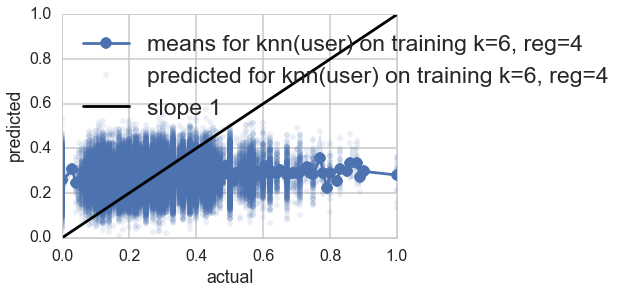

In [116]:
compare_results(at,pt, model="knn(user) on training k=6, reg=4", predicteds=True)

In [118]:
k = range(1,1000,250)
reg = range(1,100,25)
rmsedict = {}
for kval in k:
    for regval in reg:
        pt, at = get_avgs_batter_nbd(validatedf, traindf, train_avgs, db, k=kval, reg=regval)
        rmse = get_rmse(at, pt)
        key = (kval, regval)
        rmsedict[key] = rmse

In [119]:
mintup=min(rmsedict, key=rmsedict.get)
mintup

(751, 76)

In [120]:
bestk, bestreg = mintup
predictions["knn"], atknn = get_avgs_batter_nbd(testdf, traindf,train_avgs, db, k=bestk, reg=bestreg)
predictions_valid["knn"], atvalid = get_avgs_batter_nbd(traindf, traindf, train_avgs, db, k=bestk, reg=bestreg)

RMSE for knn(user) on test k=751, reg=76 0.134342532559


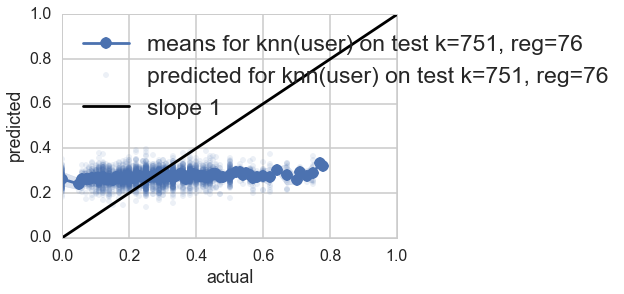

In [121]:
ax, rmse_knn = compare_results(testdf.AVG, predictions['knn'], model=("knn(user) on test k=" + str(bestk) + ", reg=" + str(bestreg)), predicteds=True)
# compare_results(testdf.stars,predictions['baseline'], model="baseline", predicteds=True, onsame=ax)